 * Running on http://localhost:5000
Press CTRL+C to quit

 * Running on http://localhost:5000
Press CTRL+C to quit
127.0.0.1 - - [07/Apr/2025 15:11:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Apr/2025 15:11:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Apr/2025 15:11:07] "GET /static/style.css HTTP/1.1127.0.0.1 - - [07/Apr/2025 15:11:07] "GET /static/style.css HTTP/1.1" 304 -
" 304 -
127.0.0.1 - - [07/Apr/2025 15:11:08] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [07/Apr/2025 15:11:08] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [07/Apr/2025 15:11:16] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [07/Apr/2025 15:11:16] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [07/Apr/2025 15:11:16] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [07/Apr/2025 15:11:16] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [07/Apr/2025 15:11:34] "POST /generate-graph HTTP/1.1" 200 -
127.0.0.1 - - [07/Apr/2025 15:11:34] "POST /generate-graph HTTP/1.1" 200 -
127.0.0.1 - - [07/Apr/2025 15:11:34

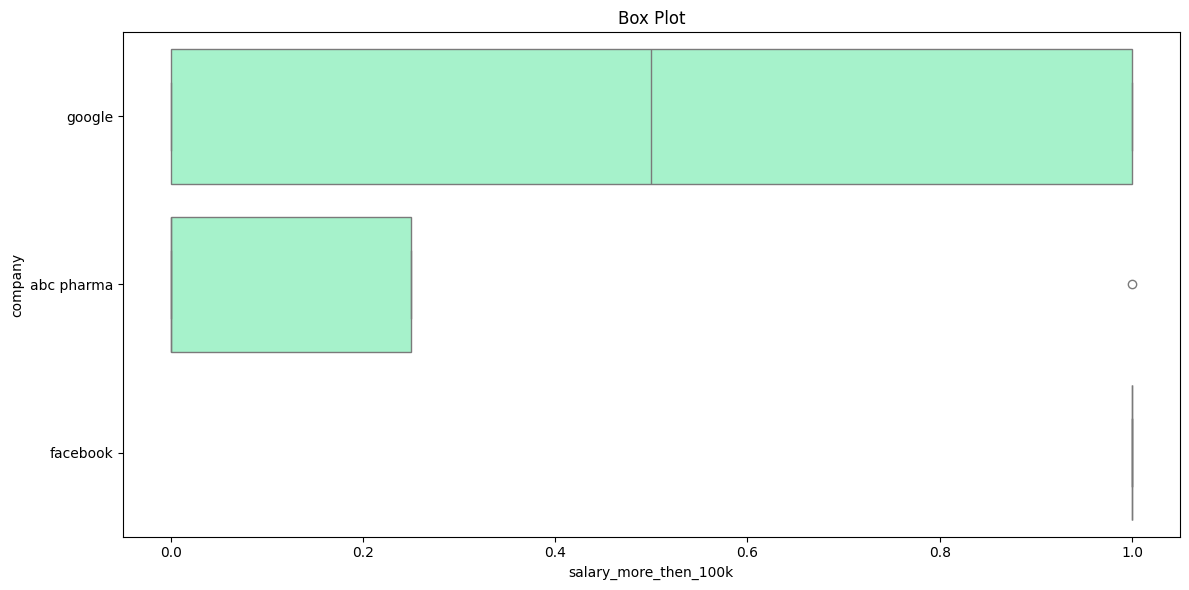

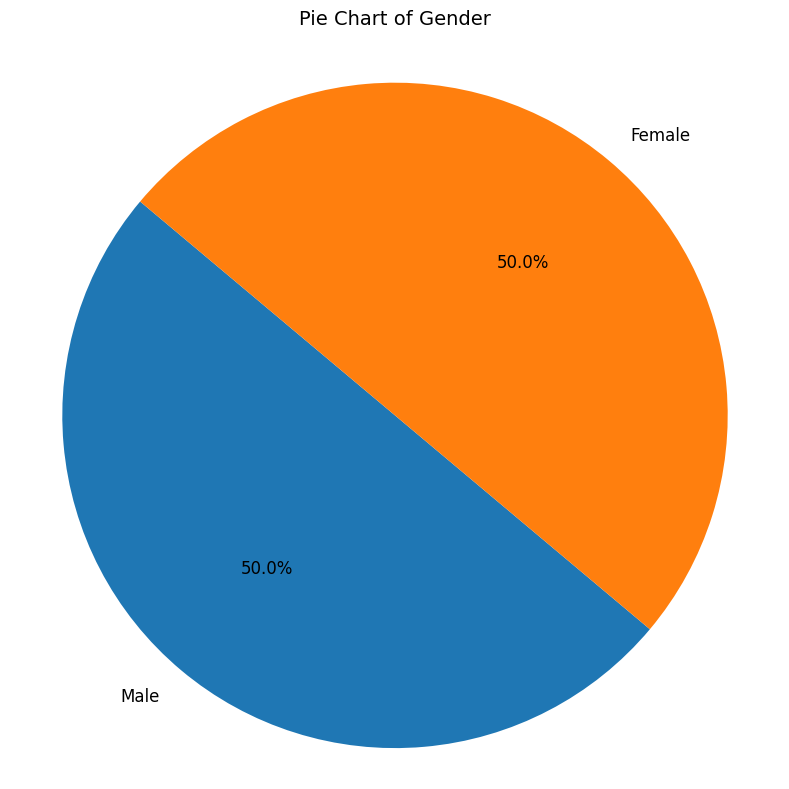

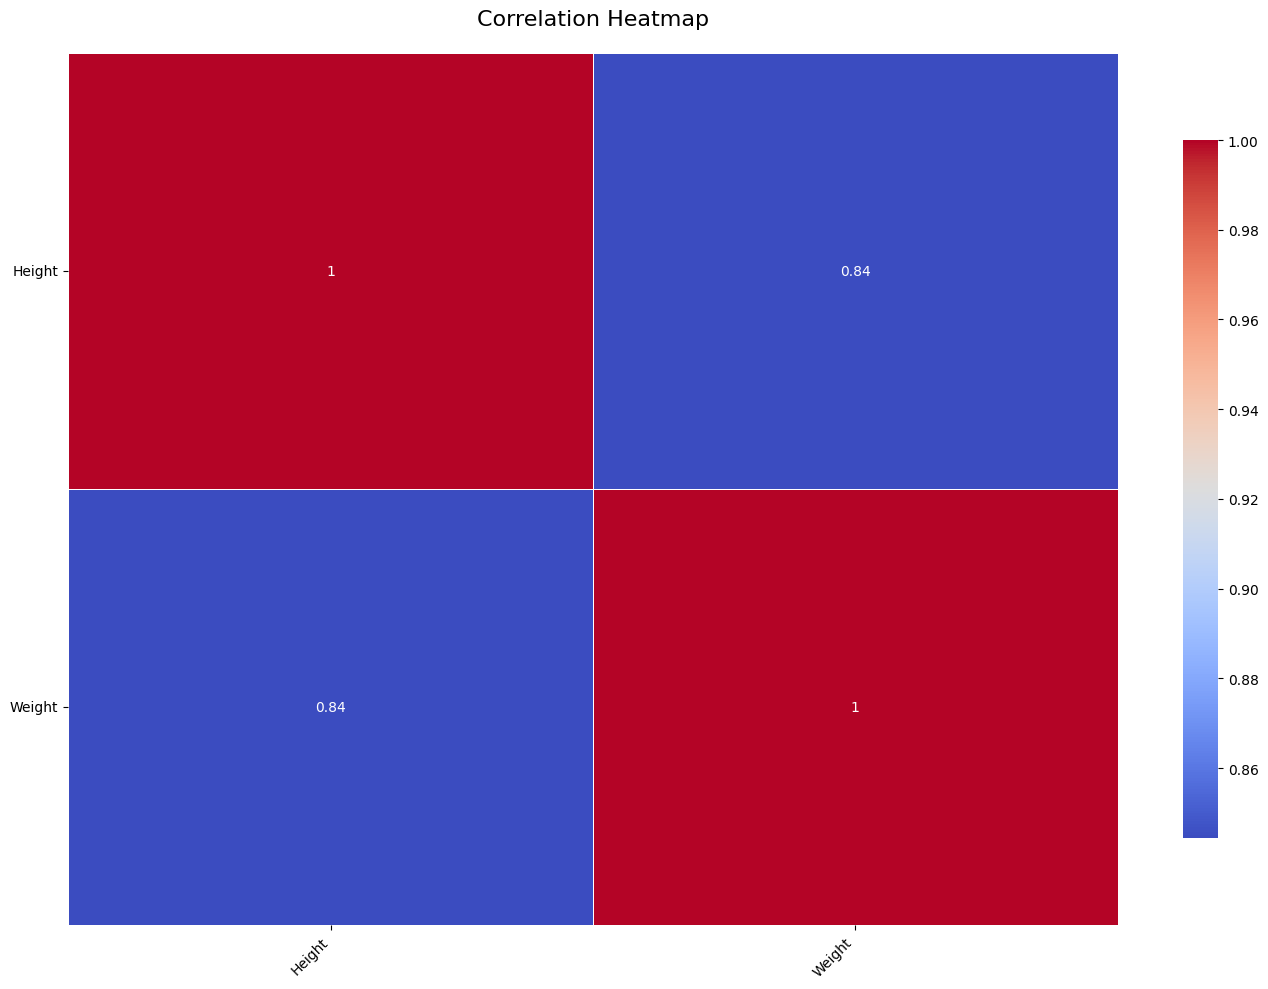

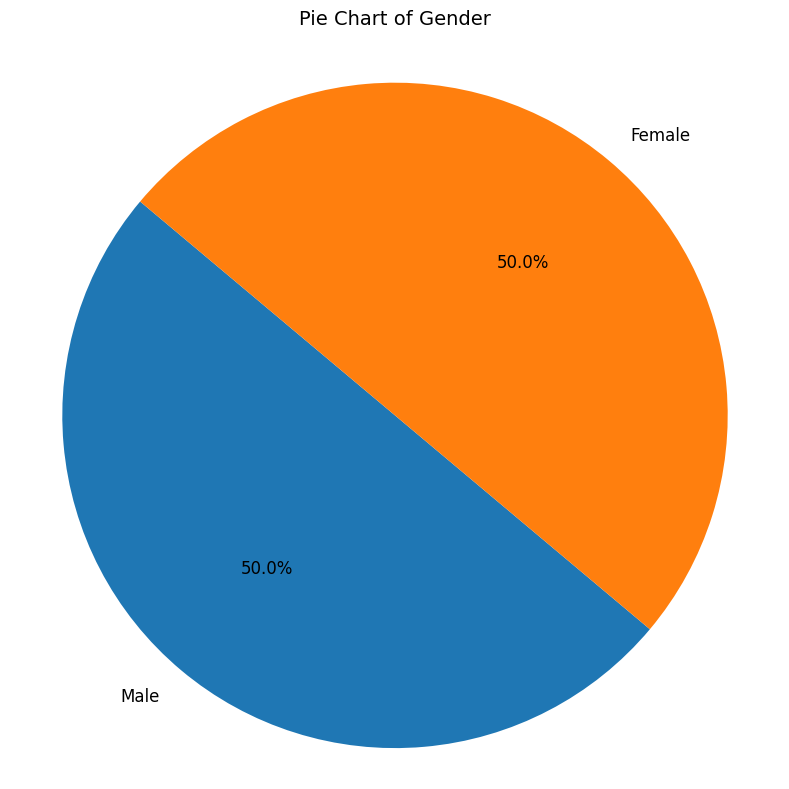

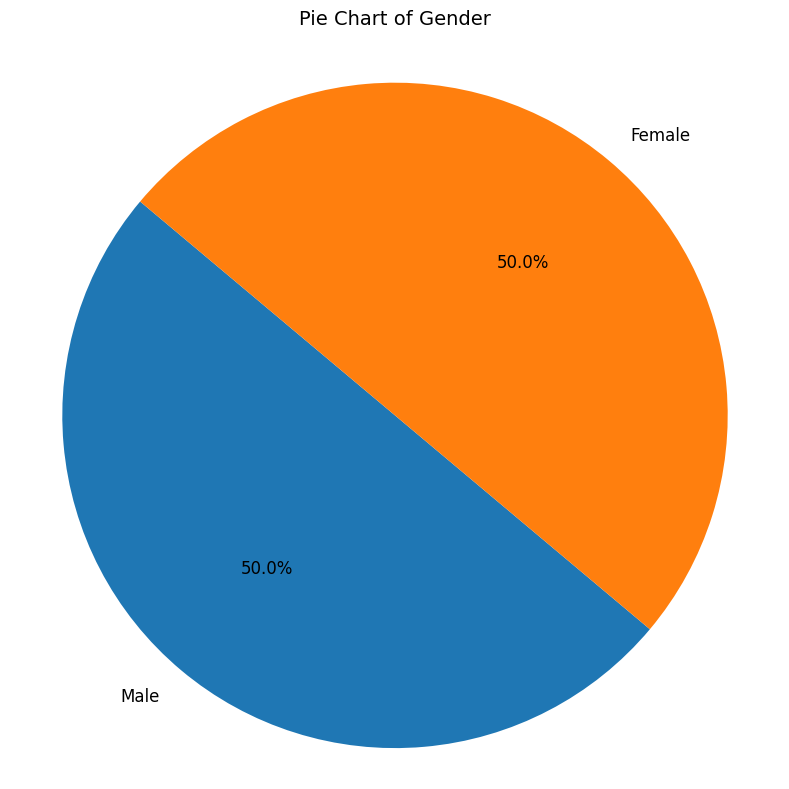

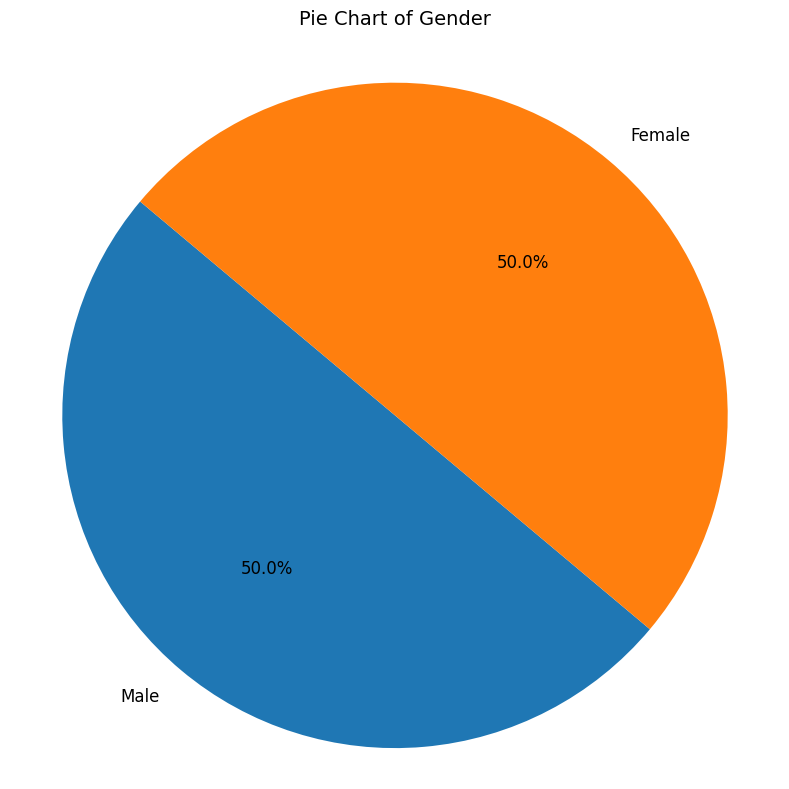

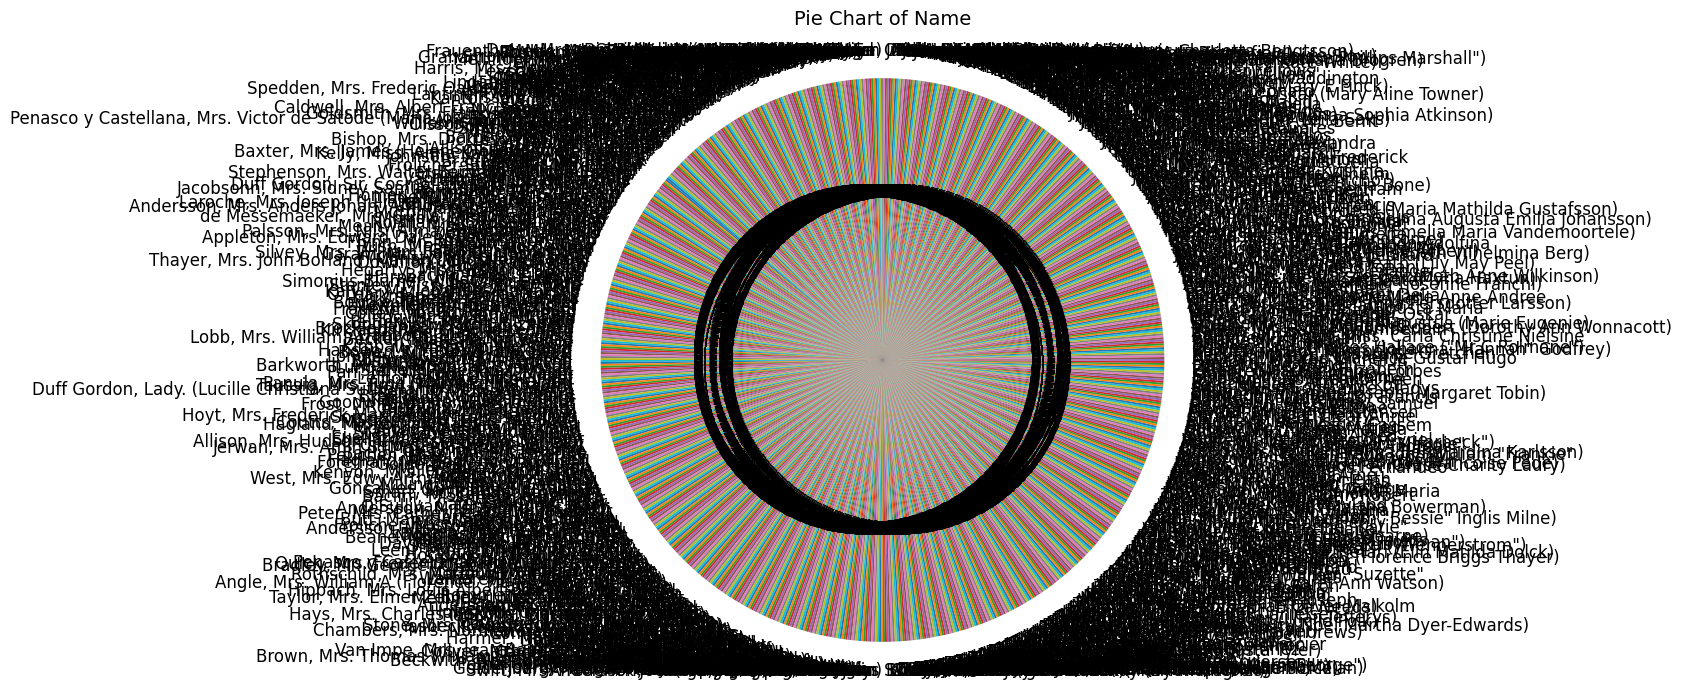

In [ ]:
from flask import Flask, render_template, request, send_file, redirect, url_for, flash
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import base64
from werkzeug.serving import run_simple

app = Flask(__name__)
UPLOAD_FOLDER = "uploads"
app.config[UPLOAD_FOLDER] = "uploads"
os.makedirs(app.config[UPLOAD_FOLDER] , exist_ok=True)
app.secret_key = 'supersecretkey' 

def cleanup_files():
    for file in os.listdir(UPLOAD_FOLDER):
        file_path = os.path.join(UPLOAD_FOLDER, file)
        os.remove(file_path)

@app.route('/')
def index():
    cleanup_files()
    return render_template('index.html')

@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return 'No file part'

    file = request.files['file']
    if file.filename == '':
        return 'No file selected'

    if file:
        file_path = os.path.join(app.config[UPLOAD_FOLDER], file.filename)
        file.save(file_path)
        df = pd.read_csv(file_path)

        table_name = os.path.splitext(file.filename)[0]

        total_columns = len(df.columns)
        total_rows = len(df)
        column_names = df.columns.tolist()

        table_html = df.head(6).to_html()
        return render_template(
            'index.html',
            table=table_html,
            filename=file.filename,
            table_name=table_name,
            columns=df.columns.tolist(),
            total_columns=total_columns,
            total_rows=total_rows,
            column_names=column_names
        )

@app.route('/generate-graph', methods=['POST'])
def generate_graph():
    graph_type = request.form['graph_type']
    filename = request.form['filename']
    x_column = request.form['x_column']
    y_column = request.form.get('y_column')
    graph_color = request.form['graph_color']

    file_path = os.path.join(app.config[UPLOAD_FOLDER], filename)
    if not os.path.exists(file_path):
        return "File not found. Please upload again."

    df = pd.read_csv(file_path)

    if not graph_type:
        flash("Please select a graph type.", "error")
        return redirect(url_for('index'))

    try:
        if graph_type == 'bar':
            plt.figure(figsize=(12, 6))
            sns.barplot(x=df[x_column], y=df[y_column], color=graph_color)
            plt.title("Bar Chart")
        elif graph_type == 'scatter':
            plt.figure(figsize=(12, 6))
            sns.scatterplot(x=df[x_column], y=df[y_column], color=graph_color)
            plt.title("Scatter Plot")
        elif graph_type == 'line':
            plt.figure(figsize=(12, 6))
            sns.lineplot(x=df[x_column], y=df[y_column], color=graph_color)
            plt.title("Line Graph")
        elif graph_type == 'histogram':
            plt.figure(figsize=(12, 6))
            sns.histplot(df[x_column].dropna(), kde=True, color=graph_color)
            plt.title("Histogram")
        elif graph_type == 'box':
            plt.figure(figsize=(12, 6))
            if y_column:
                sns.boxplot(x=df[x_column], y=df[y_column], color=graph_color)
            else:
                sns.boxplot(y=df[x_column], color=graph_color)
            plt.title("Box Plot")
        elif graph_type == 'heatmap':
            numeric_df = df.select_dtypes(include=['number'])
            if numeric_df.empty or numeric_df.shape[1] < 2:
                flash("Heatmap requires at least 2 numeric columns.", "error")
                return redirect(url_for('index'))

            fig, ax = plt.subplots(figsize=(14, 10))
            sns.heatmap(
                numeric_df.corr(),
                annot=True,
                cmap='coolwarm',
                linewidths=0.5,
                annot_kws={"size": 10},
                cbar_kws={"shrink": 0.8},
                ax=ax
            )
            ax.set_title("Correlation Heatmap", fontsize=16, pad=20)

            # ✅ Set label rotations on the actual axis
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            fig.tight_layout()
        elif graph_type == 'pie':
            categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
            if not categorical_cols:
                flash("Pie chart requires at least one categorical column.", "error")
                return redirect(url_for('index'))

            column_for_pie = categorical_cols[0]
            value_counts = df[column_for_pie].value_counts()

            plt.figure(figsize=(8, 8))
            plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
            plt.title(f"Pie Chart of {column_for_pie}", fontsize=14, pad=20)
            plt.axis('equal')
            plt.tight_layout()
        else:
            return "Invalid graph type selected."

        img = io.BytesIO()

        # Dynamic tick label adjustment (excluding pie and heatmap)
        if graph_type not in ['pie', 'heatmap']:
            plt.xticks(rotation=0)
            plt.draw()
            ax = plt.gca()

            x_labels = ax.get_xticklabels()
            if len(x_labels) > 10:
                step = max(1, len(x_labels) // 10)
                plt.xticks(
                    ticks=range(0, len(x_labels), step),
                    labels=[label.get_text() for i, label in enumerate(x_labels) if i % step == 0],
                    rotation=45,
                    ha='right'
                )

            y_labels = ax.get_yticklabels()
            if any(label.get_window_extent().height > ax.figure.get_size_inches()[1] * ax.figure.dpi / len(y_labels)
                   for label in y_labels):
                plt.yticks(rotation=45, va='top')

        plt.tight_layout()
        graph_filename = f"graph_{filename.split('.')[0]}.png"
        graph_filepath = os.path.join(app.config[UPLOAD_FOLDER], graph_filename)
        plt.savefig(graph_filepath)

        plt.savefig(img, format='png')
        img.seek(0)
        graph_url = base64.b64encode(img.getvalue()).decode()
        graph_html = f'<img src="data:image/png;base64,{graph_url}" class="img-fluid">'
        download_url = f"/download-graph/{graph_filename}"

        return render_template(
            'index.html',
            table=df.head().to_html(),
            filename=filename,
            plot=graph_html,
            columns=df.columns.tolist(),
            download_url=download_url
        )

    except Exception as e:
        print(e)
        return f"Error generating graph: {str(e)}"

@app.route('/download-graph/<graph_filename>')
def download_graph(graph_filename):
    graph_filepath = os.path.join(app.config[UPLOAD_FOLDER], graph_filename)
    if not os.path.exists(graph_filepath):
        return "Graph file not found."
    return send_file(graph_filepath, as_attachment=True)

@app.route('/about_graphs')
def about_graphs():
    return render_template('about_graphs.html')

if __name__ == '__main__':
    run_simple('localhost', 5000, app)